In [1]:
import pandas as pd
import matplotlib.pyplot as plt
!pip install pywaffle
from pywaffle import Waffle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 57.6 MB/s eta 0:00:00


# Load data

In [2]:
df = pd.read_csv('/content/sample_data/processed.csv')
df

,Institution,Course,actor.id,timestamp,verb.id,object.definition.type,result.score.scaled,result.success,result.completion,Teaching
0,UEF,Advanced Data Management Systems,0,2023-07-07 18:55:47,viewed,course,NaN,False,False,Flipped classroom
1,UEF,Advanced Data Management Systems,0,2023-07-07 15:21:18,viewed,link,NaN,False,False,Flipped classroom
2,UEF,Advanced Data Management Systems,0,2023-07-07 15:08:13,viewed,link,NaN,False,False,Flipped classroom
3,UEF,Advanced Data Management Systems,0,2023-07-07 15:08:10,viewed,course,NaN,False,False,Flipped classroom
4,UEF,Advanced Data Management Systems,0,2023-07-07 09:03:32,viewed,course,NaN,False,False,Flipped classroom
...,...,...,...,...,...,...,...,...,...,...
299286,BMU,Computer Networks,820,2023-06-11 22:57:27,answered,cmi.interaction,1.000,True,True,Flipped classroom
299287,BMU,Computer Networks,799,2023-05-16 00:05:45,answered,cmi.interaction,0.000,False,True,Flipped classroom
299288,BMU,Computer Networks,788,2023-05-12 22:10:50,completed,assessment,0.375,True,True,Flipped classroom
299289,BMU,Computer Networks,788,2023-02-27 22:45:33,completed,module,NaN,False,False,Flipped classroom


In [3]:
df.describe()

,actor.id,result.score.scaled
count,299291.000000,11558.00000
mean,366.884003,0.78472
std,219.070187,0.35866
min,0.000000,0.00000
25%,169.000000,0.70000
50%,307.000000,1.00000
75%,576.000000,1.00000
max,828.000000,1.00000


# Analysis

In [4]:
color_df = pd.DataFrame({
    'Institution': df['Institution'].unique(),
    'color': ['red', 'blue', 'green', 'yellow']
})
color_df = color_df.merge(df[['Course', 'Institution']].drop_duplicates(), how='left')

In [5]:
color_df

,Institution,color,Course
0,UEF,red,Advanced Data Management Systems
1,UEF,red,Human Factors of Interactive Technology
2,SU,blue,Human-computer interaction
3,SU,blue,e-Learning
4,UL,green,Computer Architecture
5,UL,green,Web Applications
6,BMU,yellow,Computer Organization
7,BMU,yellow,Computer Networks


## Average number of interactions by user

In [6]:
df_value_counts = df['Course'].value_counts()
df_value_counts

Human Factors of Interactive Technology    134855
Computer Architecture                       74112
e-Learning                                  26545
Web Applications                            20699
Advanced Data Management Systems            18435
Human-computer interaction                  15774
Computer Organization                        5263
Computer Networks                            3608
Name: Course, dtype: int64

In [7]:
colors = [color_df[color_df['Course'] == course].iloc[0][['color']].iloc[0] for course in list(df['Course'].value_counts().to_frame().index)]

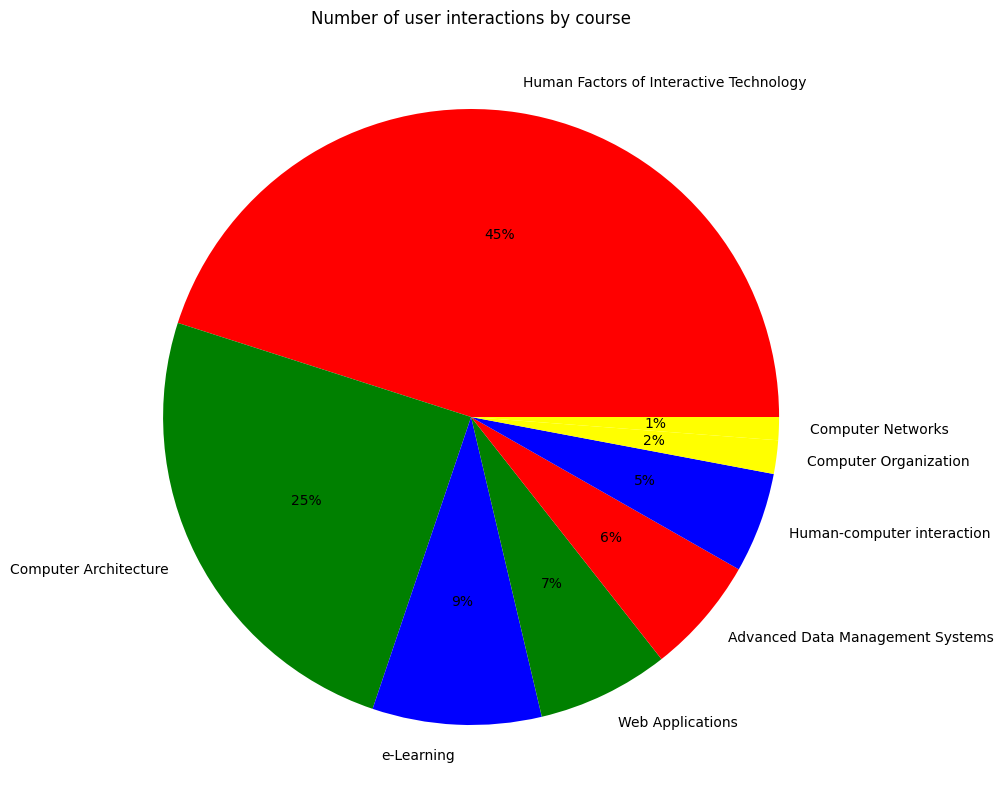

In [8]:
plt.figure(figsize=(10,10))
plt.title("Number of user interactions by course")
plt.pie(
    df['Course'].value_counts().to_frame()['Course'],
    labels=df['Course'].value_counts().to_frame().index,
    autopct='%.0f%%',
    colors=colors
)
plt.show()

In [9]:
data = {k: v for k, v in zip(
    df['Course'].value_counts().to_frame().index,
    df['Course'].value_counts().to_frame()['Course']
)}
data

{'Human Factors of Interactive Technology': 134855,
 'Computer Architecture': 74112,
 'e-Learning': 26545,
 'Web Applications': 20699,
 'Advanced Data Management Systems': 18435,
 'Human-computer interaction': 15774,
 'Computer Organization': 5263,
 'Computer Networks': 3608}

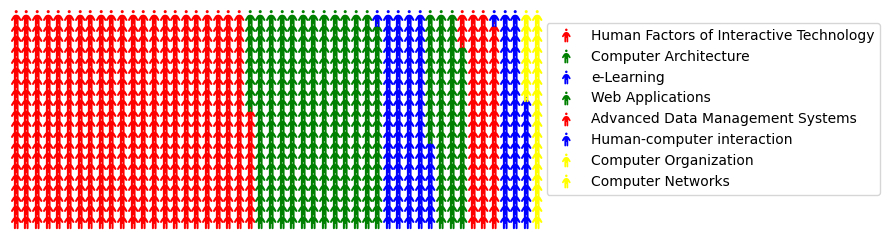

In [10]:
fig = plt.figure(
    FigureClass=Waffle,
    rows=20,
    columns=50,
    values=data,
    colors=colors,
    legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1)},
    icons='person',
    font_size=12,
    icon_legend=True,
    figsize=(9, 10)
)
plt.show()

Number of users in each course:

In [11]:
df_actor_count = df[['Course', 'actor.id']].groupby(['Course']).nunique()
df_actor_count

,actor.id
Course,
Advanced Data Management Systems,82
Computer Architecture,99
Computer Networks,41
Computer Organization,79
Human Factors of Interactive Technology,259
Human-computer interaction,120
Web Applications,67
e-Learning,82


**Mean** interaction count for each user (by course):

In [12]:
df.groupby(['Course', 'actor.id']).size().groupby(level=0).mean()

Course
Advanced Data Management Systems           224.817073
Computer Architecture                      748.606061
Computer Networks                           88.000000
Computer Organization                       66.620253
Human Factors of Interactive Technology    520.675676
Human-computer interaction                 131.450000
Web Applications                           308.940299
e-Learning                                 323.719512
dtype: float64

**Median** interaction count for each user (by course):

In [13]:
df.groupby(['Course', 'actor.id']).size().groupby(level=0).median()

Course
Advanced Data Management Systems           250.5
Computer Architecture                      718.0
Computer Networks                           88.0
Computer Organization                       73.0
Human Factors of Interactive Technology    524.0
Human-computer interaction                  86.5
Web Applications                           268.0
e-Learning                                 317.5
dtype: float64

**Human-computer interaction** may have a lot of outlier actors. Let's check for **outlier values**.

In [14]:
actor_interactions = [
    [
        df[df['Course'] == course_name].groupby(['actor.id']).size().to_frame('size')['size']
        for course_name in df['Course'].unique()
    ],
    [
        course_name
        for course_name in df['Course'].unique()
    ],
]

In [15]:
colors = [color_df[color_df['Course'] == course].iloc[0][['color']].iloc[0] for course in actor_interactions[1]]

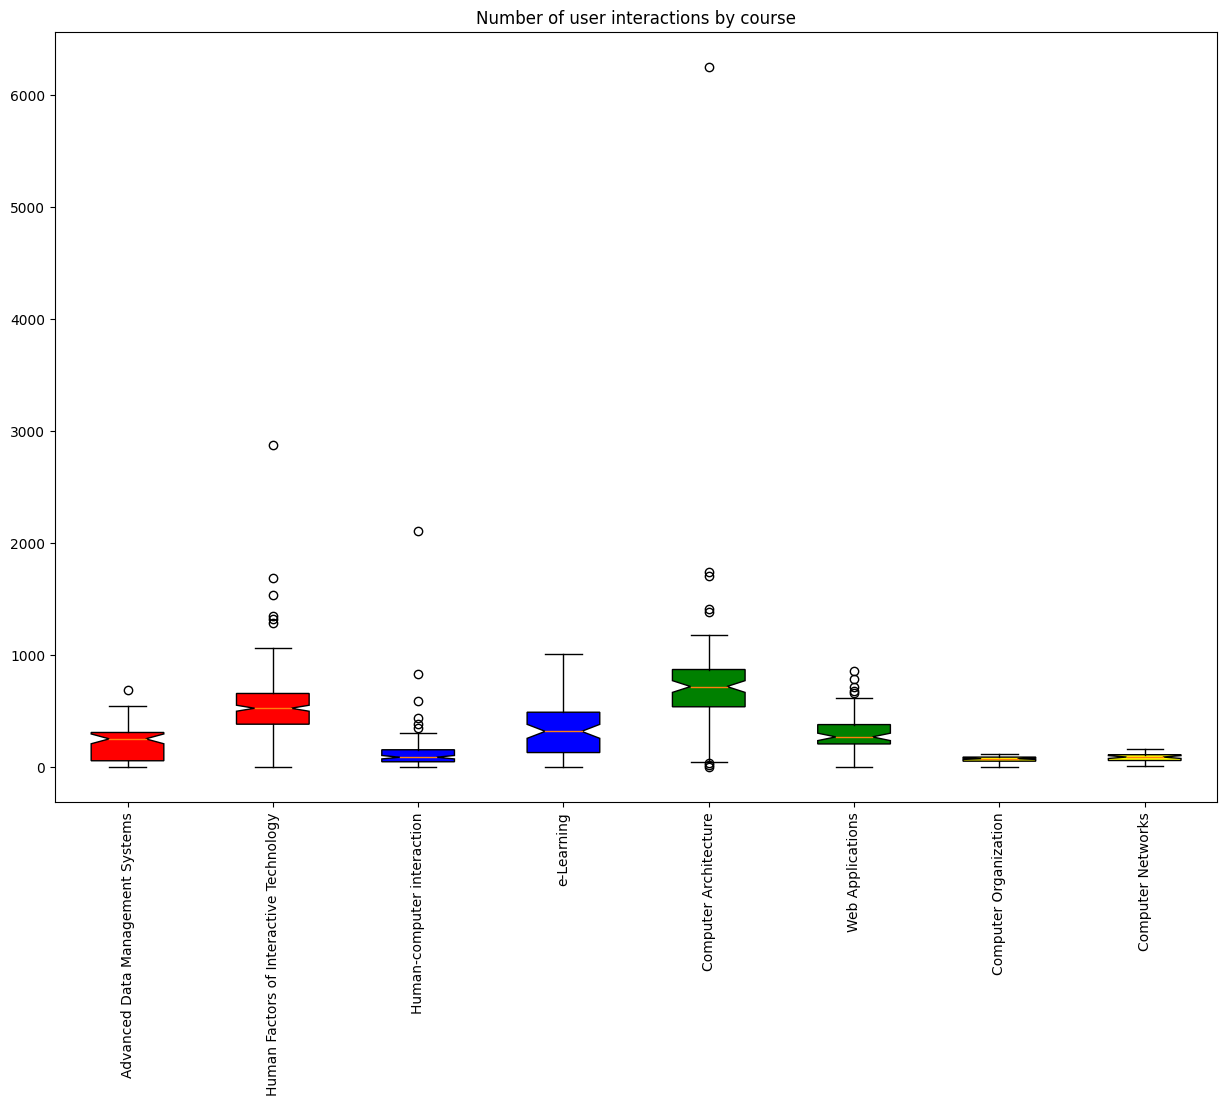

In [16]:
plt.figure(figsize=(15,10))
plt.title("Number of user interactions by course")
boxpl = plt.boxplot(
    actor_interactions[0],
    notch=True,
    patch_artist=True,
    labels=actor_interactions[1],
)
for patch, color in zip(boxpl['boxes'], colors):
    patch.set_facecolor(color)

plt.xticks(rotation=90)
plt.show()

## Number of forum / discussion interactions

In [17]:
df[(df['object.definition.type'] == 'forum-topic') | (df['object.definition.type'] == 'discussion')][['verb.id']].value_counts()

verb.id
viewed     35898
create       931
dtype: int64

In [18]:
df[df['verb.id'] == 'create'][['object.definition.type']].value_counts()

object.definition.type
discussion                931
dtype: int64

Number of people in the course who have created a discussion:

In [19]:
df[df['verb.id'] == 'create'][['Course', 'actor.id']].groupby(['Course']).nunique()

,actor.id
Course,
Advanced Data Management Systems,1
Computer Architecture,2
Human Factors of Interactive Technology,236
Human-computer interaction,3
Web Applications,2
e-Learning,35


## "Popularity" vs number of enrolled people

In [20]:
df_median_interaction = df.groupby(['Course', 'actor.id']).size().groupby(level=0).median().to_frame('median').reset_index()
df_median_interaction

,Course,median
0,Advanced Data Management Systems,250.5
1,Computer Architecture,718.0
2,Computer Networks,88.0
3,Computer Organization,73.0
4,Human Factors of Interactive Technology,524.0
5,Human-computer interaction,86.5
6,Web Applications,268.0
7,e-Learning,317.5


In [21]:
df_median_count = df_median_interaction.merge(df_actor_count.reset_index().drop_duplicates(), how='left')
df_median_count = df_median_count.merge(df[['Course', 'Teaching']].drop_duplicates(), how='right')
df_median_count

,Course,median,actor.id,Teaching
0,Advanced Data Management Systems,250.5,82,Flipped classroom
1,Human Factors of Interactive Technology,524.0,259,Project-based
2,Human-computer interaction,86.5,120,Project-based
3,e-Learning,317.5,82,Flipped classroom
4,Computer Architecture,718.0,99,Flipped classroom
5,Web Applications,268.0,67,Project-based
6,Computer Organization,73.0,79,Project-based
7,Computer Networks,88.0,41,Flipped classroom


In [22]:
colors = [
    color_df[color_df['Course'] == course].iloc[0][['color']].iloc[0]
    for course
    in list(df_median_count['Course'].value_counts().to_frame().index)
]
colors

['red', 'red', 'blue', 'blue', 'green', 'green', 'yellow', 'yellow']

In [23]:
markers = [
    (
        '*'
        if df_median_count[df_median_count['Course'] == course].iloc[0]['Teaching'] == 'Flipped classroom'
        else 'o'
    )
    for course
    in list(df_median_count['Course'].value_counts().to_frame().index)
]
markers

['*', 'o', 'o', '*', '*', 'o', 'o', '*']

[]

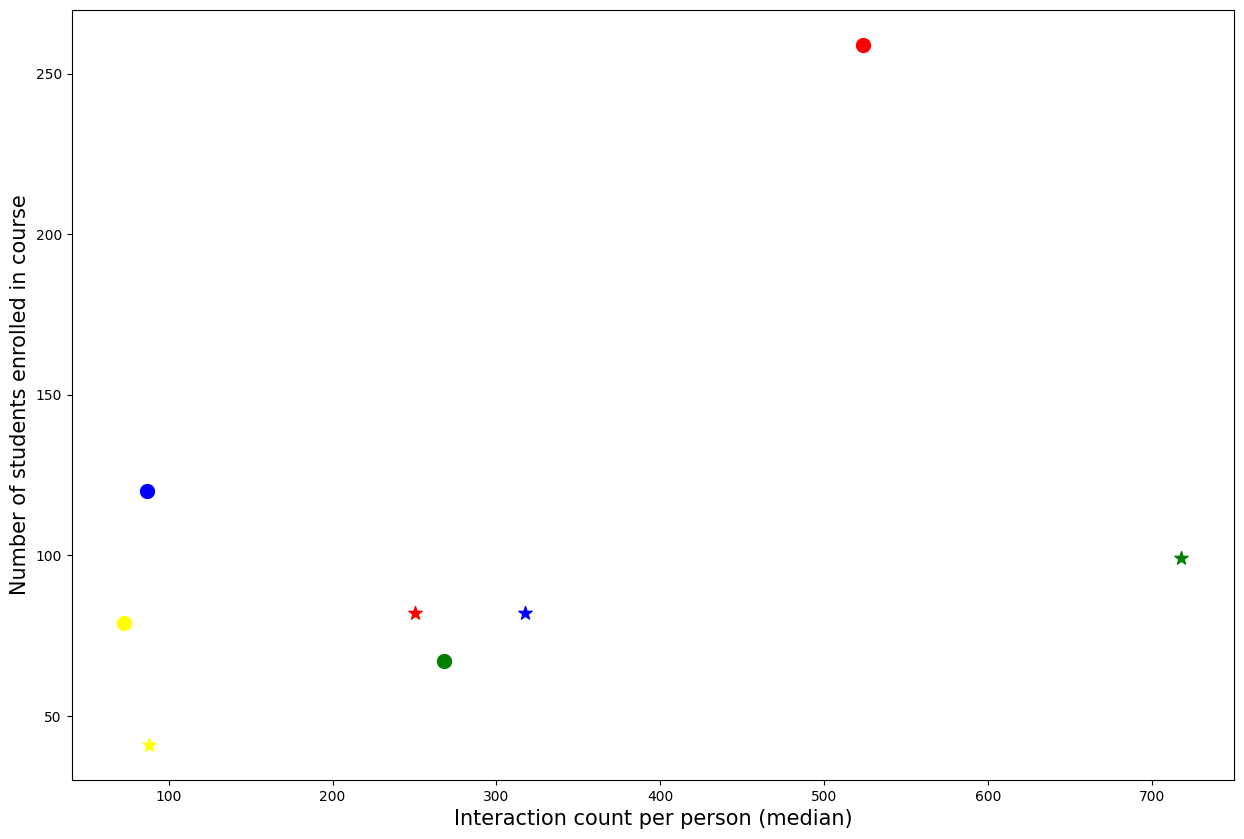

In [24]:
plt.figure(figsize=(15,10))
for xp, yp, color, marker in zip(
        df_median_count['median'],
        df_median_count['actor.id'],
        colors,
        markers
):
    plt.scatter(
        x=xp,
        y=yp,
        c=color,
        marker=marker,
        s=100
    )
plt.xlabel('Interaction count per person (median)', fontsize=15)
plt.ylabel('Number of students enrolled in course', fontsize=15)
plt.plot()